### Set up libraries

In [28]:
import pandas as pd
import numpy as np

from textblob import TextBlob  # for sentiment analysis
import spacy 
# python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)
%matplotlib inline

In [3]:
# Set up and add to stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS
# add to stopwords
stop_words.update(['\'s', '\''])

### Import data
Data from: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/GMFCTR

In [4]:
# Open the file
df = pd.read_csv('data/news_articles.csv', encoding='unicode_escape')
df = df.iloc[:,0:6]

In [5]:
# Save out the name of news publication
df['source'] = [url.split('/')[2] for url in df['article_source_link']]

In [6]:
# Drop rows with no article text
print('Shape before:', df.shape)
df = df.dropna(subset=['text'])
print('Shape after dropping rows with no article text:', df.shape)
df = df.dropna(subset=['title'])
print('Shape after dropping rows with no article title:', df.shape)

index_to_drop = df[df['title'] == 'Quotable'].index
# Delete these row indexes from dataFrame
df.drop(index_to_drop, inplace=True)
print('Shape after dropping rows with article title \'quotable\':', df.shape)
 
index_to_drop = df[df['title'].apply(lambda title: 'in brief' in title.lower())].index
# Delete these row indexes from dataFrame
df.drop(index_to_drop, inplace=True)
print('Shape after dropping rows with \'in brief\' in title:', df.shape)

# Drop rows with very short articles
df = df[df['text'].map(len) > 150]
print('Shape after dropping rows with articles shorter than 150 char:', df.shape)


Shape before: (3824, 7)
Shape after dropping rows with no article text: (3791, 7)
Shape after dropping rows with no article title: (3732, 7)
Shape after dropping rows with article title 'quotable': (3716, 7)
Shape after dropping rows with 'in brief' in title: (3694, 7)
Shape after dropping rows with articles shorter than 150 char: (3665, 7)


### Explore the data

#### What are the lengths of the article text?

[Text(0.5, 0, 'log(length of article text (chars))')]

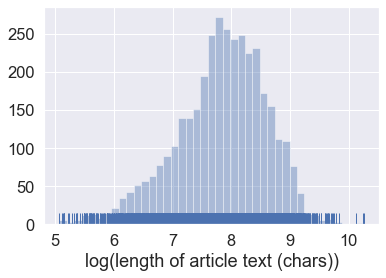

In [445]:
article_lens = df['text'].apply(len)
g = sns.distplot(np.log(article_lens), kde=False, rug=True)
g.set(xlabel="log(length of article text (chars))")

### Preprocess data

In [212]:
# Preprocess text
#TODO: Make this more performant and not traverse everything each time? use textblob?
#TODO: Add pydoc comments

def preprocess_text(text):
    # Tokenize
    doc = nlp(text)

    # Remove punctuation & stopwords
    doc = [t for t in doc if t.text not in stop_words and t.pos_ != 'PUNCT']
    # Normalize (convert non-text to text)
    
    # Stemming/Lemmatization (& lowercase & strip)
    doc = [t.lemma_.lower().strip() for t in doc]

    return doc

#### (testing step - restricting dataset size)

In [191]:
df = df.head(50)
df.shape

# cluster the news articles to figure out what topics they generally are about
# calculate a sentiment score (polarity & subjectivity) for each -- use the mean and rms? (as magnitude measure)
# pull out average polarity (just ran it on entire doc)
# pull out average subjectivity (just ran it on entire article)

# pull out 3 most "intense/polarizing" sentences from very polarized articles



(50, 8)

### Clustering (based on title)

In [213]:
def cluster_text(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(tokenizer=preprocess_text,
                                 max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
     #TODO: play with max & min document frequency

    tfidf_model = vectorizer.fit_transform(texts)
    
    # Return a dataframe of all features (words in the corpus)
#     tfidf_model_array = normalize(tfidf_model).toarray()
#     feature_names = pd.DataFrame(tfidf_model_array, columns=vectorizer.get_feature_names())
    
    # Fit to the model
    #TODO: add a random state
    kmeans = KMeans(n_clusters=clusters).fit(tfidf_model)
 
    return kmeans.labels_

#### Optimizing the clustering

From: 
* https://towardsdatascience.com/k-means-clustering-8e1e64c1561c
* https://www.kaggle.com/dfoly1/k-means-clustering-from-scratch

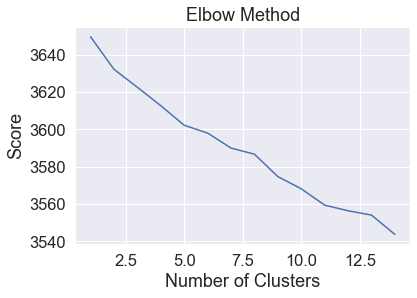

In [446]:
texts = df['title']

# don't need stopwords or lowercase because already done in preprocessing
vectorizer = TfidfVectorizer(tokenizer=preprocess_text)  # also excluded: max_df, min_df
tfidf_model = vectorizer.fit_transform(texts)

# Return a dataframe of all features (words in the corpus)
tfidf_model_array = normalize(tfidf_model).toarray()
feature_names = pd.DataFrame(tfidf_model_array, columns=vectorizer.get_feature_names())

number_clusters = range(1, 15)

#DESC: elbow method: estimating the model using various numbers of clusters and 
# calculating the negative of the within-cluster sum of squares for each number of clusters chosen using the score method from sklearn
kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
score = [kmeans[i].fit(tfidf_model).score(tfidf_model) for i in range(len(kmeans))]
score = [i*-1 for i in score]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

The data is generally too similar, so I'm not getting an elbow shape.

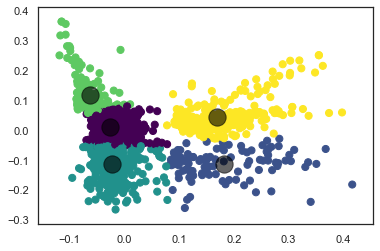

In [253]:
num_clusters = 5

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tfidf_model_array)

test_e = kmeans[num_clusters-1]

fitted = test_e.fit(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

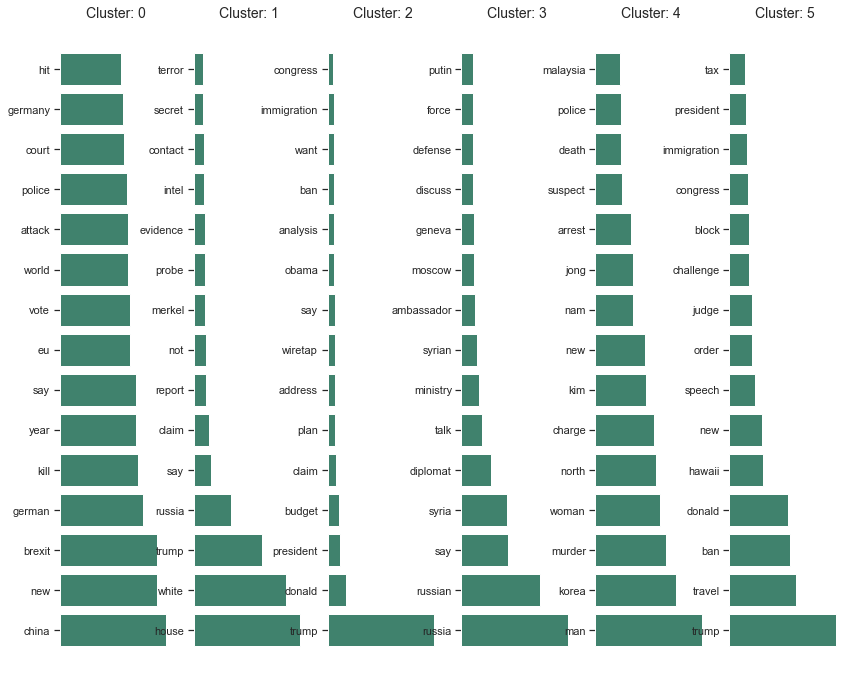

In [245]:
def get_top_features_cluster(tfidf_model_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tfidf_model_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

dfs = get_top_features_cluster(tfidf_model_array, predicted_values, 15)

def plot_features(dfs):
    fig = plt.figure(figsize=(14,12))
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.set_title("Cluster: "+ str(i), fontsize = 14)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#40826d')
        yticks = ax.set_yticklabels(df.features)
        plt.yticks(np.arange(min(x), max(x)+1, 1.0))
        plt.xticks([], [])
    plt.show();
plot_features(dfs)



In [254]:
# Save cluster to df (NOTE:cluster based on TITLE)

df['cluster'] = fitted.labels_

### Get sentiment

In [7]:
def get_sentiment(article):
    try:
        return TextBlob(article).sentiment
    except:
        return None

# df.drop(['pol_sub', 'polarity', 'subjectivity'], axis = 1) 
    
df['pol_sub'] = df.text.apply(get_sentiment)
df['polarity'] = df.pol_sub.apply(lambda x: x[0])
df['subjectivity'] = df.pol_sub.apply(lambda x: x[1])

#NOTE: these scores are for entire articles, not titles


In [35]:
df['pol_sub_title'] = df.title.apply(get_sentiment)
df['polarity_title'] = df.pol_sub_title.apply(lambda x: x[0])
df['subjectivity_title'] = df.pol_sub_title.apply(lambda x: x[1])

### Analyze & visualize the sentiment

#### What are the sentiments of different news sources?

NOTES:
* BBC is UK
* TASS is a Russian news agency
* DW is German
* Aljazeera is Qatari
* China Daily is China
* RTE is Irish

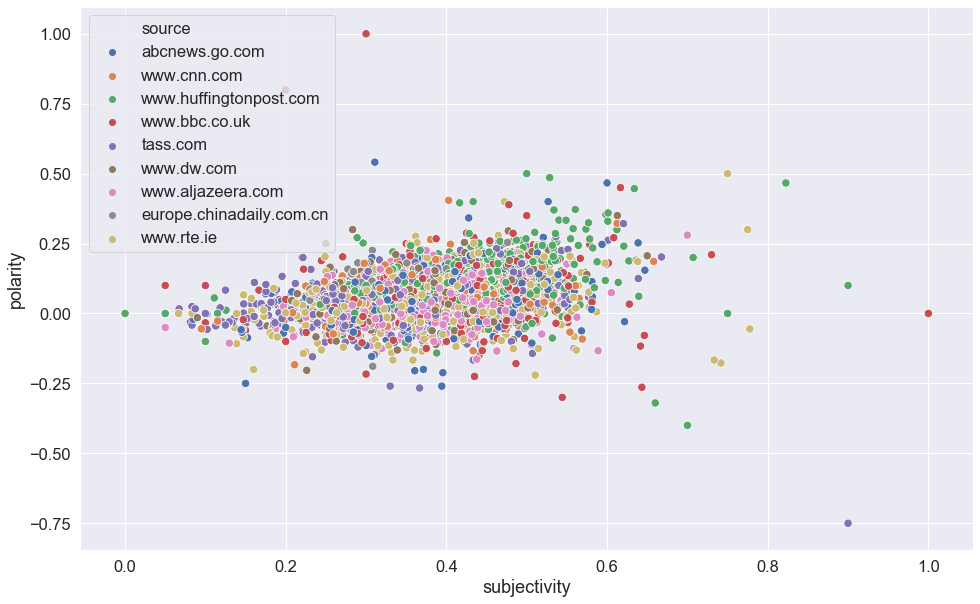

In [274]:
# Goal: Scatter plot. y axis polarity. x axis subjectivity. legend = news outlet
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.5)
# cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x='subjectivity', y="polarity", hue="source", s=70,
#                      palette=cmap,
                     data=df)


#### What are the sentiments of English-first news sources?

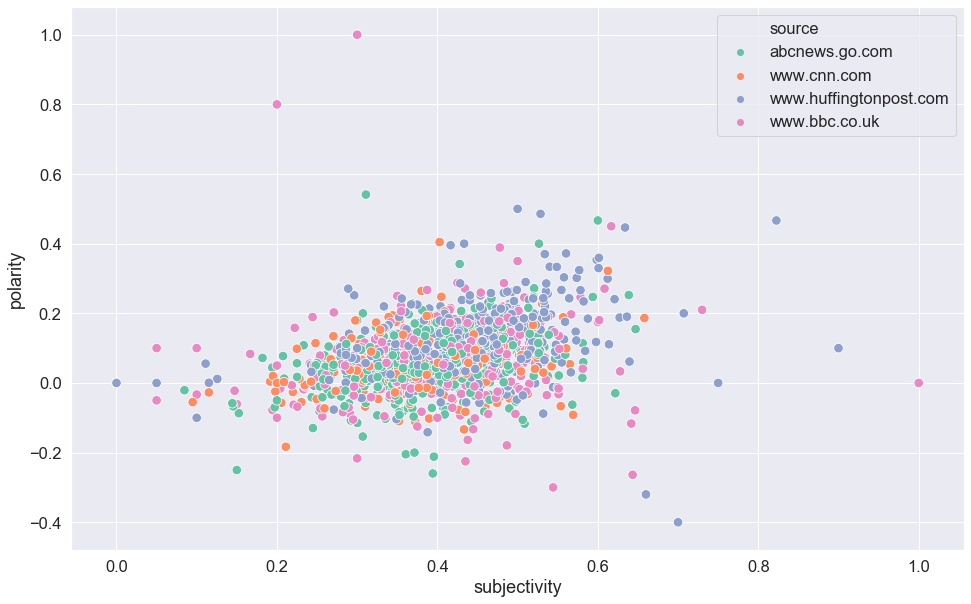

In [288]:
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.5)
# cmap = sns.cubehelix_palette(as_cmap=True)  # can't use as palette b/c hue list is strings

english_sources = ['abcnews.go.com','www.cnn.com','www.huffingtonpost.com','www.bbc.co.uk'] 
df_english_news = df.loc[df['source'].isin(english_sources)]

ax = sns.scatterplot(x='subjectivity', y="polarity", hue="source", s=90, palette="Set2",
                    data=df_english_news)

#### What is the average polarity & sentiment of each of those sources?

In [304]:
# english_sources = ['abcnews.go.com','www.cnn.com','www.huffingtonpost.com','www.bbc.co.uk'] 
df_english_news = df.loc[df['source'].isin(english_sources)]

subjectivity = df_english_news.groupby('source').subjectivity.mean()
polarity= df_english_news.groupby('source').polarity.mean()
df_senti_mean = pd.concat([subj, polarity], axis=1).reset_index()


[(-1, 1), (0, 1)]

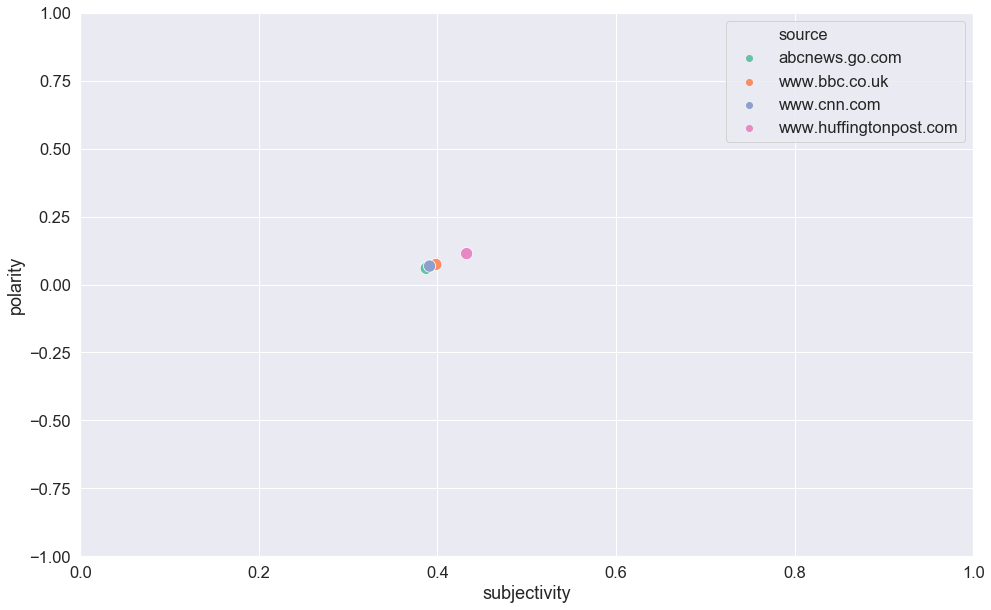

In [393]:
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.5)
# cmap = sns.cubehelix_palette(as_cmap=True)  # can't use as palette b/c hue list is strings

ax = sns.scatterplot(x='subjectivity', y="polarity", hue='source', s=150, palette="Set2",
                    data=df_senti_mean)
ax.set(xlim=(0,1),ylim=(-1,1))

#### How sentimentally extreme are all these articles?

i. how does that compare across different sources?

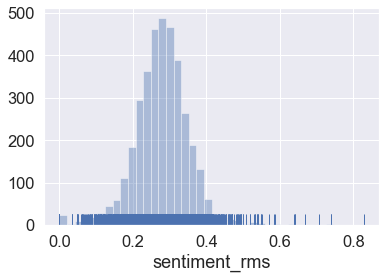

In [361]:
# Graph all the sentiment RMSs
sns.distplot(df_sorted_by_senti['sentiment_rms'], bins=40, kde=False, rug=True);

<Figure size 1152x720 with 0 Axes>

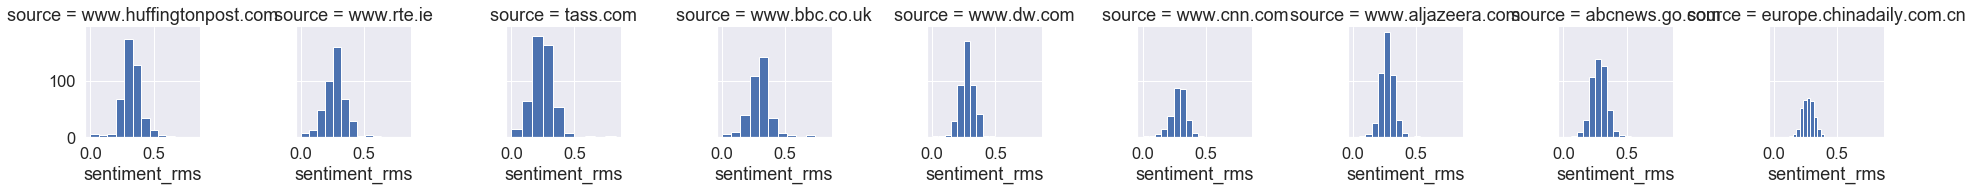

In [370]:
plt.figure(figsize=(16, 10))
g = sns.FacetGrid(df_sorted_by_senti, col="source")
g.map(plt.hist, "sentiment_rms");



# sns.set(style="white", palette="muted", color_codes=True)

# # Set up the matplotlib figure
# f, axes = plt.subplots(3, 3, figsize=(7, 7), sharex=True)
# sns.despine(left=True)

# # subplots
# for i in range(1,9):
#     d = df_sorted_by_senti[df_sorted_by_senti['source']==]
#     sns.distplot(d['sentiment_rms'], hist=False, rug=True, color="r", ax=axes[0, 1])
# df_sorted_by_senti['sentiment_rms'], bins=40, kde=False, rug=True)

# plt.setp(axes, yticks=[])
# plt.tight_layout()

#### What are the titles of the most polar and most subjective articles? The most objective? -- The outlier articles
* What topics do they cover?
* What outlets do they come from?

*(note that the polarity and subjectivity come from the full text of the article)*

In [423]:
# Filter out the most extreme articles based on arbitrary thresholds
subj_thresh = [0.05, 0.8]
pol_thresh = [-0.25, 0.45]

df_most_subjective = df[df['subjectivity'] > subj_thresh[1]].sort_values(by='polarity')
df_most_objective = df[df['subjectivity'] < subj_thresh[0]].sort_values(by='polarity')
df_most_positive = df[df['polarity'] > pol_thresh[1]].sort_values(by='subjectivity')
df_most_negative = df[df['polarity'] < pol_thresh[0]].sort_values(by='subjectivity')

# df_most_extreme_subj = df[df['subjectivity'].between(subj_thresh[0], subj_thresh[1])].sort_values(by='polarity')
# df_most_extreme_pol = df[df['polarity'].between(pol_thresh[0], pol_thresh[1])].sort_values(by='polarity')


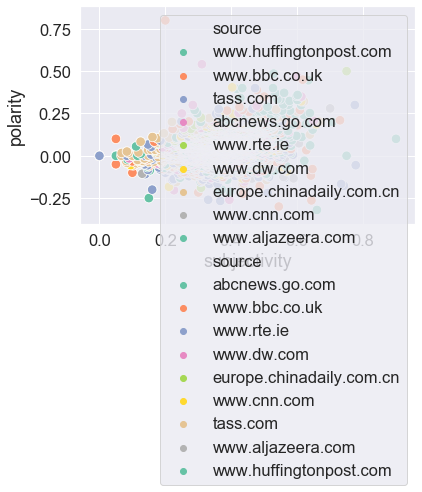

In [425]:
# Plot all of these
ax = sns.scatterplot(x='subjectivity', y="polarity", hue="source", s=90, palette="Set2",
                    data=df_most_subjective)
ax = sns.scatterplot(x='subjectivity', y="polarity", hue="source", s=90, palette="Set2",
                    data=df_most_objective)
ax = sns.scatterplot(x='subjectivity', y="polarity", hue="source", s=90, palette="Set2",
                    data=df_most_positive)
ax = sns.scatterplot(x='subjectivity', y="polarity", hue="source", s=90, palette="Set2",
                    data=df_most_negative)

In [416]:
print('\n Most subjective articles: \n')
print(df_most_subjective.shape)
print(df_most_subjective[['title', 'text', 'pol_sub']].values)


 Most subjective articles: 

(4, 12)
[["Trump slams 'haters' for accusing him of sympathizing with Russia"
  "WASHINGTON, February 7. /TASS/. US President Donald Trump has once again stressed that all the accusations of him sympathizing with Russia are groundless.  I don't know Putin, have no deals in Russia, and the haters are going crazy - yet Obama can make a deal with Iran, #1 in terror, no problem!  After being elected the US resident, Trump has been repeatedly slamming the US media.-  Donald Trump's path to presidency "
  Sentiment(polarity=-0.75, subjectivity=0.9)]
 ["Chechen leader's daughter makes fashion designer debut"
  "The head of the Firdaws fashion house and daughter of Chechen republic head, Aishat Kadyrova, presented her-first collection, which included 30 works.- Kadyrova's collection features modest, floor length designs that comply with the Chechen Republic's strict Islamic dress code."
  Sentiment(polarity=0.1, subjectivity=0.9)]
 ['Trump Voter Shocked To Find Th

In [417]:
print('\n Most objective articles: \n')
print(df_most_objective.shape)
print(df_most_objective[['title', 'text', 'pol_sub']].values)




 Most objective articles: 

(9, 12)
[['Will robots replace workers by 2030?'
  "According to some predictions, robots will go on to replace people in a third of UK jobs by 2030. So should we be worried by the rise of the machines? BBC Breakfast's Tim Muffet reports."
  Sentiment(polarity=0.0, subjectivity=0.0)]
 ["'It gets lonely': Being conservative on a liberal campus"
  "What is it like to be a conservative on a liberal college campus in the age of President Trump? At George Washington University and American University in the nation's capital, conservatives tell the BBC what's changed. Video by Charlie Northcott, Charlotte Pamment and Iliana Hagenah."
  Sentiment(polarity=0.0, subjectivity=0.0)]
 ['Couple who met over a bin finally marry in their 80s'
  'Joan Neininger and Ken Selway, who are both in their 80s, met back in 1975 in Gloucester city centre. Ken was homeless at the time and met Joan while he was rifling through a bin. After decades of as they say, "ups and downs", the

In [418]:
print('\n Most positive articles: \n')
print(df_most_positive.shape)
print(df_most_positive[['title', 'text', 'pol_sub']].values)


 Most positive articles: 

(6, 12)
[['Deputy Speaker orders MPs to stop whistling during Brexit vote'
  'Scottish National Party MPs were told off by Deputy Speaker Lindsay Hoyle for whistling and singing the EU anthem "Ode to joy" in the Commons chamber as MPs voted on Brexit legislation. MPs agreed by 494 votes to 122 to let the government begin the UK\'s departure from the EU.'
  Sentiment(polarity=0.8, subjectivity=0.2)]
 ['Grammy Awards 2017: List of winners'
  'The music world\'s biggest stars were honored with Grammy Awards on what\'s called "music\'s biggest night" Sunday. Golden gramophones were handed out inside Los Angeles\' Staples Center. Coming into Sunday, Beyonce led the field with nine total nominations. Still, Adele went home the big winner, taking home the award for Album of the Year for "25." Still, Bey wasn\'t completely empty handed. Before the televised awards had begun, she had already took home one for Best Music Video for "Formation." She also won the award f

In [419]:
print('\n Most negative articles: \n')
print(df_most_negative.shape)
print(df_most_negative[['title', 'text', 'pol_sub']].values)


 Most negative articles: 

(7, 12)
[['Man accused of involvement in militant groupings extradited from Serbia to Russia'
  'MOSCOW, March 28. /TASS/. Serbia has extradited to Russia Timur Emirbekov, who is accused of involvement in paramilitary units, the Russian Interior Ministry said at its homepage. "Interpol bureau staff has extradited Timur Emirbekov, who is accused of crimed punishable under Part II, Article 208 of Russia\'s Criminal Code," said Irina Volk, the ministry\'s official spokesperson. If proven, a crime falling under this clause of the Criminal Code can bring on from eight to fifteen years in jail. A criminal case for Emirbekov citing his involvement in an armed conflict on the side of militant groupings was instituted in June 2015. He was detained in the course of search on the territory of Serbia. Officers of Interpol\'s national bureau in Russia delivered Emirbekov to Moscow on Tuesday.'
  Sentiment(polarity=-0.26, subjectivity=0.33)]
 ['Investigators initiate crim

##### Observations
* The most polar news articles tend to involve a lot of quotes (in general, news is likely pretty objective)

##### Calculate RMS

In [68]:
# Create new column that combines pol and sub scores with RMS
data = np.array([df.polarity**2, df.subjectivity**2])
df['sentiment_rms'] = np.sqrt(np.average(data, axis=0))

In [394]:
# Sort the data by that new sentiment score
df_sorted_by_senti = df.sort_values(by='sentiment_rms')
print(df_sorted_by_senti.head()['title'])
print(df_sorted_by_senti.tail())

print('\n The most extreme article: \n')
print(df_sorted_by_senti.tail(1)['title'].values)
print(df_sorted_by_senti.tail(1)['text'].values)

print('\n The top 5 most extreme article: \n')
print(df_sorted_by_senti.tail(5)['title'].values)
print(df_sorted_by_senti.tail(5)['text'].values)

90                   Will robots replace workers by 2030?
1504             Woman and child rescued from Dublin fire
1295               Man dies in Kildare workplace incident
751     'It gets lonely': Being conservative on a libe...
2127    Brexit: Scottish leader seeks UK split as EU d...
Name: title, dtype: object
      article_id publish_date  \
1862        1863     2017/3/2   
1810        1811     2017/3/2   
2877        2878    2017/3/18   
2613        2614    2017/3/16   
163          164     2017/2/7   

                                    article_source_link  \
1862     http://www.rte.ie/news/2017/0301/856524-lotto/   
1810                     http://tass.com/society/933468   
2877  http://www.huffingtonpost.com/2017/03/18/one-d...   
2613  http://www.huffingtonpost.com/2017/03/15/easte...   
163                        http://tass.com/world/929462   

                                                  title  \
1862                 One winner of 12.9m Lotto jackpot   
1810  Chech

In [367]:
# How many articles are not subjective and not polar?
df_not_subj_not_polar = df_sorted_by_senti[df_sorted_by_senti['sentiment_rms'] == 0]
print('{} articles are not subjective and not polar'.format(df_not_subj_not_polar.shape[0]))

# What are their titles and sources?
print(df_not_subj_not_polar[['title','source']])

23 articles are not subjective and not polar
                                                  title  \
1238  Sen. Elizabeth Warren Slams Pruitt: 'Big Pollu...   
1978   Live NI Assembly vote turnout highest since 1998   
1930  Kremlin brushes aside opposition figure's alle...   
3695  Selena Gomez Debuts Emotional New Song For "?3...   
3249  Capitol Acquisition Corp. III to Combine with ...   
1366  Border guard detain in Crimea Ukrainian nation...   
1352  Islamic State battle: Fierce gunfight outside ...   
1295             Man dies in Kildare workplace incident   
2949  Recap: Ireland shatter England's Grand Slam dr...   
2661  Turkey has no plans to integrate Russia's S-40...   
1250  Couple who met over a bin finally marry in the...   
1006                                 NECROMANCER - Ep.5   
1460  Caitlyn Jenner's message to Donald Trump: 'Cal...   
3607  Domestic Violence Survivor Marries First Respo...   
751   'It gets lonely': Being conservative on a libe...   
279        

#### Do the groups of posts that the clustering algorithm's pulled out have any particular grouping of sentiment?

i. for all

ii. for the English-first

Other explorations on the same theme: certain countries? certain figures like Trump? Topics like Brexit?

<Figure size 1152x1440 with 0 Axes>

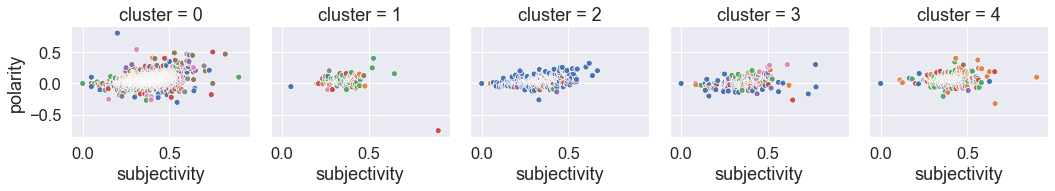

In [433]:
plt.figure(figsize=(16, 20))
g = sns.FacetGrid(df_sorted_by_senti, col="cluster")
g.map(sns.scatterplot, "subjectivity", "polarity", "source")

#### How does sentiment of article text compare with sentiment of the title?

Hypothesis: article text is less extreme than the title (to get people to click)
* Is this true for some sources more than others?
* Is this true for some topics more than others?

In [37]:
# Look at farthest distances
senti_title = df[['polarity_title', 'subjectivity_title']].values.tolist()
senti_text = df[['polarity', 'subjectivity']].values.tolist()
df['senti_diff_title_text'] = pairwise.paired_distances(X=senti_title, Y=senti_text)

In [42]:
df_sorted_senti_diff = df.sort_values(by='senti_diff_title_text',ascending=False)

In [48]:
print(df_sorted_senti_diff.head()[['senti_diff_title_text', 'pol_sub_title', 'pol_sub', 'title', 'text']].values)

[[1.2462208478734 Sentiment(polarity=-1.0, subjectivity=1.0)
  Sentiment(polarity=0.10902793128856957, subjectivity=0.43156051395413086)
  "Trump Says He Should Let Obamacare 'Collapse.' That's Cruel And Irresponsible."
  'Before even taking office, and well before the Republican bid to repeal and "replace"?the Affordable Care Act, President Donald Trump started saying the best political strategy for his party would be to let the law\'s health insurance exchanges "Collapse"?and then blame Democrats for it. Immediately after Friday\'s colossally embarrassing flameout of the GOP\'s American Health Care Act, Trump was at it again. "I"ve been saying for the last year and a half that the best thing we can do politically speaking is let Obamacare explode,"?Trump said at the White House. "I think the losers are Nancy Pelosi and Chuck Schumer, because now they own Obamacare. They own it, 100 percent own it."?And Trump\'s not the only one floating this notion. Here\'s Sen. Lindsey Graham (R-S.C

In [47]:
print(df_sorted_senti_diff.tail(3)[['title', 'text', 'senti_diff_title_text']].values)

[['Woman and child rescued from Dublin fire'
  'A woman and child have been rescued from a fire in a house on the North Circular Road in Dublin.- Four pumps attended the blaze at a three-storey property after the alarm was raised around 5.20am.- Fifteen-people were in the building at the time.- One pump remains at the scene but the fire has now been brought under control.- No injuries have been reported.- A cat was also rescued from the fire.- NCR 0515: Firefighters rescued 2 people after a fire on 2nd floor. 15 residents evacuated. Never delay if you hear a fire alarm #Dublin pic.twitter.com/OAaQdvegBV "?Dublin Fire Brigade (@DubFireBrigade) February 24, 2017'
  0.0]
 ['US dock landing ship USS Carter Hall enters Black Sea - Pentagon'
  'MOSCOW, March 18. /TASS/. The amphibious Harpers Ferry-class dock landing ship USS Carter Hall has entered the Black Sea, the Naples-headquartered US 6th fleet press service said Saturday. "The amphibious dock landing ship USS Carter Hall (LSD 50) and

Observation:
* Most subjective and polar are, again, when quotes are being used.

##### Plot the distribution of the difference
NOTE: this is a little hard to understand conceptually--it's kind of a "meta-statistic" (like the error of the error). 

What would be easier (for comprehension purposes): seeing movement/links between the sentiment of the article text and the sentiment of the article title

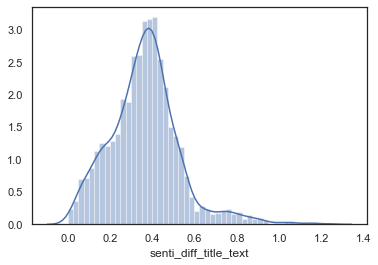

In [49]:
sns.distplot(df.senti_diff_title_text)

##### Plot movement (see note above)

"plotting lines in pairs" "connected scatter plots"

In [64]:
# only do this for the top 20
df_sorted_senti_diff_subset = df_sorted_senti_diff.head(10)

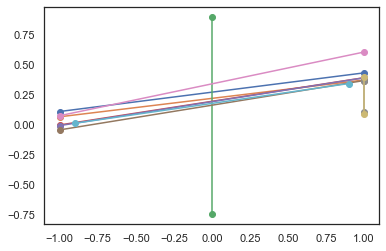

In [65]:
for i in range(0, len(df_sorted_senti_diff_subset)):
    plt.plot(df_sorted_senti_diff_subset[['polarity_title', 'subjectivity_title']].iloc[i].values, df_sorted_senti_diff_subset[['polarity', 'subjectivity']].iloc[i].values, 'o-')

plt.show()

#TODO: this doesn't show "directionality" -- e.g. if the title was more extreme v the article text or vice versa

##### What tends to be more extreme: the title or the article text?

In [69]:
data = np.array([df.polarity_title**2, df.subjectivity_title**2])
df['sentiment_rms_title'] = np.sqrt(np.average(data, axis=0))

In [70]:
df['senti_rms_diff'] = df['sentiment_rms_title'] - df['sentiment_rms']
# if senti_rms_diff is negative, the text is more extreme. if +, title more extreme.

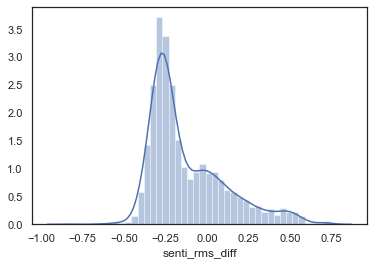

In [71]:
# plot the results
sns.distplot(df['senti_rms_diff'])

If hypothesis is correct, we'd expect to see more + values than - values.

But we actually see more - values than + values, by quite a bit.

*Possible reasons for this:*
* Article text uses quotes more often than titles do. **Can we test this?**

In [72]:
df['senti_rms_diff'].describe()

count    3665.000000
mean       -0.122120
std         0.231009
min        -0.828402
25%        -0.286367
50%        -0.211878
75%         0.007907
max         0.738297
Name: senti_rms_diff, dtype: float64

###### Testing if senti_rms_article_text > senti_rms_title means more quotes in the article text
(in plain English--if an article is more "extreme" than its title, it's b/c of quotes

In [79]:
#NOTE: using " character to count number of quotes can be faulty.
# Some of the articles have " used inappropriately (e.g. as a possessive)

df['num_quotes_in_text'] = df['text'].apply(str.count, args='\"')

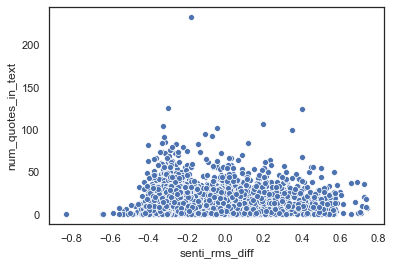

In [82]:
# Plotting to see if there's correlation
sns.scatterplot(df['senti_rms_diff'],df['num_quotes_in_text'])

observations:
* Definitely not seeing any type of correlation. (maybe if you take out articles with less than 50 quotes?)
* Also, what the hell are the articles that have 100+ quotes?

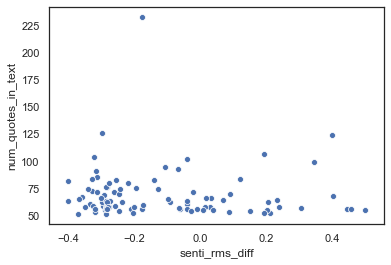

In [85]:
df_lots_of_quotes = df[df.num_quotes_in_text > 50]
sns.scatterplot(df_lots_of_quotes['senti_rms_diff'],df_lots_of_quotes['num_quotes_in_text'])

# Observations:
# Still doesn't really look like there's any real correlation

In [84]:
df.sort_values('num_quotes_in_text', ascending=False).head()[['num_quotes_in_text', 'text']].values

array([[233,
        'The modern musical walked away with five awards -- more than any other movie -- at the British Academy of Film and Television Arts awards Sunday, including best film and individual honors for Emma Stone and director Damien Chazelle. "La La Land" had been up for seven awards. Its BAFTA success came one day before the final Oscar ballot opens up, further consolidating its position as frontrunner for top honors at the 89th Academy Awards, which are being held on February 26. In the last decade, the recipient of the BAFTA for Best Film has gone on to win the Oscar for Best Picture six times. "Lion" was another big winner, picking up trophies for Best Adapted Screenplay and Best Supporting Actor for Dev Patel. The Best Supporting Actress category once again belonged to Viola Davis for her role as long-suffering wife Rose in "Fences", continuing her unstoppable awards streak headed into the Oscars. At a news conference after the ceremony, Davis voiced her skepticism ove

* First one with 200+ quotes is because it has quotes around the name of movies

## Possible areas for improvement   

* Using sentiment analysis for phrases instead of entire sentences (or even words)
* Improving how StanfordNLP is parsing sentences (some of them are clauses instead)--pulling out punctuation in preprocessing may help this?
* How good is Stanford NLP's dependency parser + pos tagger? (false positives? false negatives?)
* Pulling out quotes when someone is saying something negative

* What metrics am I trying to measure against/to improve?"